In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer

In [22]:
all_hourly_data = pd.read_csv('all_hourly_data.csv')
print(all_hourly_data.head())

        interval_start_local    date  hour  north_x_load  south_load  \
0  2018-01-01 00:00:00-06:00  1/1/18     0      21198.80    14046.47   
1  2018-01-01 01:00:00-06:00  1/1/18     1      21176.60    14176.73   
2  2018-01-01 02:00:00-06:00  1/1/18     2      21234.65    14265.94   
3  2018-01-01 03:00:00-06:00  1/1/18     3      21365.95    14360.66   
4  2018-01-01 04:00:00-06:00  1/1/18     4      21691.43    14516.28   

   west_x_load  houston_load  total_load  lmp_HB_BUSAVG  coal_and_lignite  \
0      4759.33      10584.52    50589.13      27.285833       15806.62550   
1      4722.19      10569.91    50645.44      27.427500       15903.98768   
2      4675.70      10559.50    50735.79      27.243333       15913.71428   
3      4673.38      10608.76    51008.76      27.770000       15932.35813   
4      4698.25      10793.93    51699.89      28.697500       15904.12724   

   ...  natural_gas  other_gen  coast_temp  east_temp  far_west_temp  \
0  ...  25122.23091   2.103656  

Trying out the following:
- Binary regression decision trees
- Bagged regression trees
- Boosted regression trees

In [24]:
all_hourly_data['interval_start_local'] = pd.to_datetime(all_hourly_data['interval_start_local'], utc = True)

# Extract time-based features
all_hourly_data['hour'] = all_hourly_data['interval_start_local'].dt.hour
all_hourly_data['dayofweek'] = all_hourly_data['interval_start_local'].dt.dayofweek
all_hourly_data['month'] = all_hourly_data['interval_start_local'].dt.month
all_hourly_data['year'] = all_hourly_data['interval_start_local'].dt.year
all_hourly_data['is_weekend'] = all_hourly_data['dayofweek'].isin([5, 6]).astype(int)

#Train-Test Split (random 70% of the dataset as the training set, remaining as the test set)

# Define X (features) and y (target - lmp_HB_BUSAVG)
X = all_hourly_data.drop(columns=['lmp_HB_BUSAVG', 'interval_start_local', 'date'])
y = all_hourly_data['lmp_HB_BUSAVG']                 

# 70/30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Single Regression Decision Tree

In [26]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

#Estimate average number of splits in unrestricted trees
num_splits_list = []

for train_index, val_index in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    tree = DecisionTreeRegressor(random_state=42)
    tree.fit(X_tr, y_tr)

    # Number of internal nodes = number of splits
    tree_structure = tree.tree_
    num_splits = tree_structure.node_count - tree_structure.n_leaves
    num_splits_list.append(num_splits)

avg_splits = np.mean(num_splits_list)
print(f"Average number of splits: {avg_splits:.2f}")

#Set limit on max number of splits as half the average
max_leaf_nodes_limit = int((avg_splits / 2) + 1)  # +1 to convert to leaves
print(f"Setting max_leaf_nodes = {max_leaf_nodes_limit}")

#Test min_samples_leaf from 1 to 50
rmse_per_leaf_size = []

for min_leaf in range(1, 51):
    fold_rmse = []
    for train_index, val_index in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        tree = DecisionTreeRegressor(
            min_samples_leaf=min_leaf,
            max_leaf_nodes=max_leaf_nodes_limit,
            random_state=42
        )
        tree.fit(X_tr, y_tr)
        preds = tree.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        fold_rmse.append(rmse)
    
    avg_rmse = np.mean(fold_rmse)
    rmse_per_leaf_size.append((min_leaf, avg_rmse))

#Find best parameter
best_leaf, best_rmse = min(rmse_per_leaf_size, key=lambda x: x[1])
print(f"\nBest min_samples_leaf: {best_leaf} with average RMSE: {best_rmse:.4f}")

Average number of splits: 40104.10
Setting max_leaf_nodes = 20053

Best min_samples_leaf: 15 with average RMSE: 136.2694


/Users/JChuang/Documents/Duke Semester 2/IDS ML/IDS705_final_project/.venv/lib/python3.13/site-packages/sklearn/ensemble/_bagging.py:1315: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/Users/JChuang/Documents/Duke Semester 2/IDS ML/IDS705_final_project/.venv/lib/python3.13/site-packages/sklearn/ensemble/_bagging.py:1315: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/Users/JChuang/Documents/Duke Semester 2/IDS ML/IDS705_final_project/.venv/lib/python3.13/site-packages/sklearn/ensemble/_bagging.py:1315: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/Users/JChuang/Documents/Duke Semester 2/IDS ML/IDS705_final_project/.venv/lib/python3.13/site-packages/sklearn/ensemble/_bagging.py:1315: UserWarni


Best number of trees: 100 with OOB MAE: 13.5491


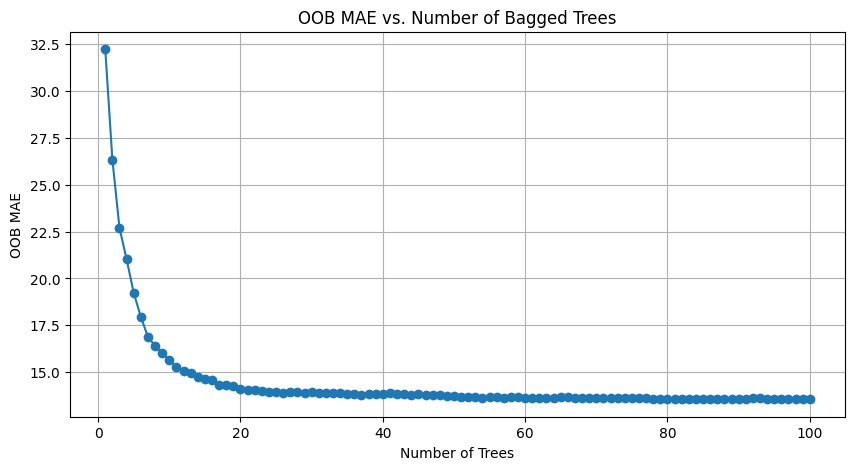

In [29]:
#Bagged regression trees

oob_errors = []

#Loop over different number of trees
for n_trees in range(1, 101):
    bagged_model = BaggingRegressor(
        estimator=DecisionTreeRegressor(),  # unpruned trees
        n_estimators=n_trees,
        oob_score=True,
        bootstrap=True,
        random_state=42,
        n_jobs=-1  # Use all cores for faster training
    )
    
    bagged_model.fit(X_train, y_train)

    #OOB prediction is only available after fitting and when oob_score=True
    if hasattr(bagged_model, 'oob_prediction_'):
        oob_mae = mean_absolute_error(y_train, bagged_model.oob_prediction_)
        oob_errors.append((n_trees, oob_mae))

oob_df = pd.DataFrame(oob_errors, columns=["n_trees", "oob_mae"])

#Find the best number of trees
best_n_trees = oob_df.loc[oob_df['oob_mae'].idxmin()]
print(f"\nBest number of trees: {int(best_n_trees['n_trees'])} with OOB MAE: {best_n_trees['oob_mae']:.4f}")

#Plot the OOB error vs. number of trees
plt.figure(figsize=(10, 5))
plt.plot(oob_df['n_trees'], oob_df['oob_mae'], marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('OOB MAE')
plt.title('OOB MAE vs. Number of Bagged Trees')
plt.grid(True)
plt.show()



Best learning rate: 0.2 with RMSE: 102.5767


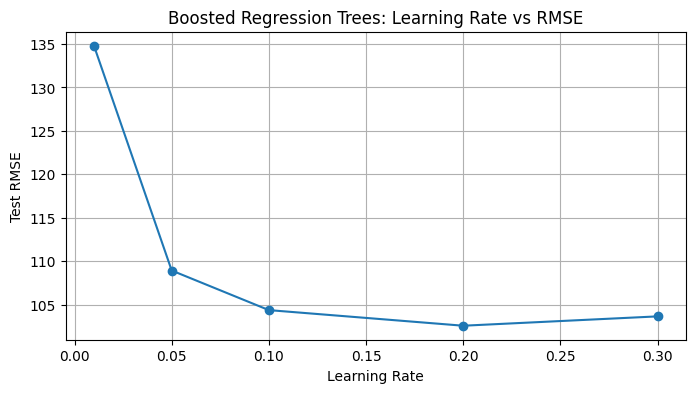

In [32]:
#Boosted regression trees

#imputing missing values (might move this up earlier and rerun all)
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# Define a range of learning rates to test
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
n_estimators = 200  # number of boosting stages (trees)
max_splits = 10     # max number of splits per tree (so max_depth=log2(max_splits + 1))

results = []

for lr in learning_rates:
    model = GradientBoostingRegressor(
        learning_rate=lr,
        n_estimators=n_estimators,
        max_depth=int(np.log2(max_splits + 1)),  # Convert number of splits to depth
        loss='squared_error',
        random_state=42
    )
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    results.append((lr, rmse))

#Find the best learning rate
best_lr, best_rmse = min(results, key=lambda x: x[1])
print(f"\nBest learning rate: {best_lr} with RMSE: {best_rmse:.4f}")

#Plot
lrs, rmses = zip(*results)
plt.figure(figsize=(8, 4))
plt.plot(lrs, rmses, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Test RMSE')
plt.title('Boosted Regression Trees: Learning Rate vs RMSE')
plt.grid(True)
plt.show()

Comparing the different trees

In [36]:
#Final Decision Tree model (best from CV)
tree_model = DecisionTreeRegressor(
    min_samples_leaf=best_leaf,
    max_leaf_nodes=max_leaf_nodes_limit,
    random_state=42
)
tree_model.fit(X_train, y_train)

#Final bagged model (best from OOB MAE tuning)
bagged_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=int(best_n_trees['n_trees']),  # based on OOB MAE tuning
    oob_score=True,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
bagged_model.fit(X_train, y_train)

# Final Boosted Tree model (best from tuning)
boosted_model = GradientBoostingRegressor(
    learning_rate=best_lr,
    n_estimators=n_estimators,
    max_depth=int(np.log2(max_splits + 1)),
    loss='squared_error',
    random_state=42
)
boosted_model.fit(X_train, y_train)

#Predict on training data
tree_preds_train = tree_model.predict(X_train)
bagged_preds_train = bagged_model.predict(X_train)
boosted_preds_train = boosted_model.predict(X_train)

#Compare MAE
tree_mae = np.sqrt(mean_absolute_error(y_train, tree_preds_train))
bagged_mae = np.sqrt(mean_absolute_error(y_train, bagged_preds_train))
boosted_mae = np.sqrt(mean_absolute_error(y_train, boosted_preds_train))

#Compute RMSE
tree_rmse = np.sqrt(mean_squared_error(y_train, tree_preds_train))
bagged_rmse = np.sqrt(mean_squared_error(y_train, bagged_preds_train))
boosted_rmse = np.sqrt(mean_squared_error(y_train, boosted_preds_train))

comparison_df = pd.DataFrame({
    "Model": ["Decision Tree", "Bagged Trees", "Boosted Trees"],
    "Train RMSE": [tree_rmse, bagged_rmse, boosted_rmse]
})

print(comparison_df)

           Model  Train RMSE
0  Decision Tree  116.491969
1   Bagged Trees   41.817129
2  Boosted Trees   39.944288
